<a href="https://colab.research.google.com/github/cocoa0409/lhy_DL_Hw/blob/master/Report_hw1_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 1: Linear Regression**

# **Load 'train.csv'**
train.csv 的資料為 12 個月中，每個月取 20 天，每天 24 小時的資料(每小時資料有 18 個 features)。

In [0]:
import sys
import pandas as pd
import numpy as np
from google.colab import drive 
!gdown --id '1wNKAxQ29G15kgpBy_asjTcZRRgmsCZRm' --output Hw1_data.zip
!unzip Hw1_data.zip
!ls

Downloading...
From: https://drive.google.com/uc?id=1wNKAxQ29G15kgpBy_asjTcZRRgmsCZRm
To: /content/Hw1_data.zip
100% 177k/177k [00:00<00:00, 67.0MB/s]
Archive:  Hw1_data.zip
  inflating: test.csv                
  inflating: train.csv               
Hw1_data.zip  sample_data  test.csv  train.csv


# **Extract Features (1)**
![圖片說明](https://drive.google.com/uc?id=1LyaqD4ojX07oe5oDzPO99l9ts5NRyArH)
![圖片說明](https://drive.google.com/uc?id=1ZroBarcnlsr85gibeqEF-MtY13xJTG47)

將原始 4320 * 18 的資料依照每個月分重組成 12 個 18 (features) * 480 (hours) 的資料。 

In [0]:
#1、读取文件
# data = pd.read_csv('gdrive/My Drive/hw1-regression/train.csv', header = None, encoding = 'big5')
data = pd.read_csv('./train.csv', encoding = 'big5')
data = data.iloc[:, 3:]
data[data == 'NR'] = 0
raw_data = data.to_numpy()

#2、整理格式
month_data = {}
for month in range(12):
    sample = np.empty([18, 480])
    for day in range(20):
        sample[:, day * 24 : (day + 1) * 24] = raw_data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample


# 整理后的文件month_data不再改动,所有不同的预测方式均从month_data提取数据

# **Extract Features (2)**
![alt text](https://drive.google.com/uc?id=1wKoPuaRHoX682LMiBgIoOP4PDyNKsJLK)
![alt text](https://drive.google.com/uc?id=1FRWWiXQ-Qh0i9tyx0LiugHYF_xDdkhLN)

每個月會有 480hrs，每 9 小時形成一個 data，每個月會有 471 個 data，故總資料數為 471 * 12 筆，而每筆 data 有 9 * 18 的 features (一小時 18 個 features * 9 小時)。

對應的 target 則有 471 * 12 個(第 10 個小時的 PM2.5)

In [0]:
x = np.empty([12 * 471, 18 * 9], dtype = float)
y = np.empty([12 * 471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value

mean_x = np.mean(x, axis = 0) #18 * 9 
std_x = np.std(x, axis = 0) #18 * 9 
for i in range(len(x)): #12 * 471
    for j in range(len(x[0])): #18 * 9 
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]

#**Split Training Data Into "train_set" and "validation_set"**
這部分是針對作業中 report 的第二題、第三題做的簡單示範，以生成比較中用來訓練的 train_set 和不會被放入訓練、只是用來驗證的 validation_set。

In [0]:
import math
x_train_set = x[: math.floor(len(x) * 0.8), :]
y_train_set = y[: math.floor(len(y) * 0.8), :]
x_validation = x[math.floor(len(x) * 0.8): , :]
y_validation = y[math.floor(len(y) * 0.8): , :]

# **Training**
![alt text](https://drive.google.com/uc?id=1xIXvqZ4EGgmxrp7c9r0LOVbcvd4d9H4N)
![alt text](https://drive.google.com/uc?id=1S42g06ON5oJlV2f9RukxawjbE4NpsaB6)
![alt text](https://drive.google.com/uc?id=1BbXu-oPB9EZBHDQ12YCkYqtyAIil3bGj)

(和上圖不同處: 下面的 code 採用 Root Mean Square Error)

因為常數項的存在，所以 dimension (dim) 需要多加一欄；eps 項是避免 adagrad 的分母為 0 而加的極小數值。

每一個 dimension (dim) 會對應到各自的 gradient, weight (w)，透過一次次的 iteration (iter_time) 學習。

In [0]:
dim = 18 * 9 + 1
w = np.zeros([dim, 1])
x = np.concatenate((np.ones([12 * 471, 1]), x), axis = 1).astype(float)
learning_rate = 100
iter_time = 1000
adagrad = np.zeros([dim, 1])
eps = 0.0000000001
for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x, w) - y, 2))/471/12)#rmse
    if(t%100==0):
        print(str(t) + ":" + str(loss))
    gradient = 2 * np.dot(x.transpose(), np.dot(x, w) - y) #dim*1
    adagrad += gradient ** 2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
np.save('weight.npy', w)

0:27.071214829194115
100:33.78905859777454
200:19.91375129819709
300:13.53106819368969
400:10.64546615844617
500:9.277353455475065
600:8.5180420459565
700:8.014061987588422
800:7.63675682477569
900:7.3365637403711235


# **Testing**
![alt text](https://drive.google.com/uc?id=1165ETzZyE6HStqKvgR0gKrJwgFLK6-CW)

載入 test data，並且以相似於訓練資料預先處理和特徵萃取的方式處理，使 test data 形成 240 個維度為 18 * 9 + 1 的資料。

In [0]:
# testdata = pd.read_csv('gdrive/My Drive/hw1-regression/test.csv', header = None, encoding = 'big5')
testdata = pd.read_csv('./test.csv', header = None, encoding = 'big5')
test_data = testdata.iloc[:, 2:]
test_data[test_data == 'NR'] = 0
test_data = test_data.to_numpy()
test_x = np.empty([240, 18*9], dtype = float)
for i in range(240):
    test_x[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2986: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(-key, value, inplace=True)


# **Prediction**
說明圖同上

![alt text](https://drive.google.com/uc?id=1165ETzZyE6HStqKvgR0gKrJwgFLK6-CW)

有了 weight 和測試資料即可預測 target。

In [0]:
w = np.load('weight.npy')
ans_y = np.dot(test_x, w)

# **Save Prediction to CSV File**


In [0]:
# **Save Prediction to CSV File**

In [0]:
import csv
with open('submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    print(header)
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)

['id', 'value']


# **Homework1_regression_report**

# **作业部分**
說明：請各位使用此 template 撰寫 report，如果想要用其他排版模式也請註明題號以及題目內容（請勿擅自更改題號），最後上傳至 GitHub 前，請務必轉成 PDF 檔，並且命名為 report.pdf，否則將不予計分。 中英文皆可，但助教強烈建議使用中文。
----------------------------------------閱讀完以上文字請刪除---------------------------------------
學號： 系級： 姓名：
備註 :
a. 1-3題的回答中，NR 請皆設為 0，其他的數值不要做任何更動。
b. 可以使用所有 advanced 的 gradient descent 技術（如 Adam、Adagrad）。
c. 1-3題請用linear regression的方法進行討論作答。

(2%) 使用四種不同的 learning rate 進行 training (其他參數需一致)，作圖並討論其收斂過程（橫軸為 iteration 次數，縱軸為 loss 的大小，四種 learning rate 的收斂線請以不同顏色呈現在一張圖裡做比較）。

(1%) 比較取前 5 hrs 和前 9 hrs 的資料（518 + 1 v.s 918 + 1）在 validation set 上預測的結果，並說明造成的可能原因（1. 因為 testing set 預測結果要上傳 Kaggle 後才能得知，所以在報告中並不要求同學們呈現 testing set 的結果，至於什麼是 validation set 請參考：https://youtu.be/D_S6y0Jm6dQ?t=1949 2. 9hr:取前9小時預測第10小時的PM2.5；5hr:在前面的那些features中，以5~9hr預測第10小時的PM2.5。這樣兩者在相同的validation set比例下，會有一樣筆數的資料）。

(1%) 比較只取前 9 hrs 的 PM2.5 和取所有前 9 hrs 的 features（91 + 1 vs. 918 + 1）在 validation set上預測的結果，並說明造成的可能原因。

(2%) 請說明你超越 baseline 的 model(最後選擇在Kaggle上提交的) 是如何實作的（例如：怎麼進行 feature selection, 有沒有做 pre-processing、learning rate 的調整、advanced gradient descent 技術、不同的 model 等等）。

# **1、不同的learning rate**
(2%) 使用四種不同的 learning rate 進行 training (其他參數需一致)，作圖並討論其收斂過程（橫軸為 iteration 次數，縱軸為 loss 的大小，四種 learning rate 的收斂線請以不同顏色呈現在一張圖裡做比較）。

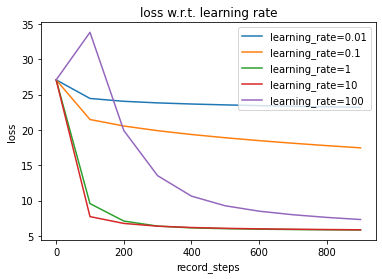

In [0]:
#1、读取文件
# data = pd.read_csv('gdrive/My Drive/hw1-regression/train.csv', header = None, encoding = 'big5')
data = pd.read_csv('./train.csv', encoding = 'big5')
data = data.iloc[:, 3:]
data[data == 'NR'] = 0
raw_data = data.to_numpy()

#2、整理格式
month_data = {}
for month in range(12):
    sample = np.empty([18, 480])
    for day in range(20):
        sample[:, day * 24 : (day + 1) * 24] = raw_data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample
# 整理后的文件month_data不再改动,所有不同的预测方式均从month_data提取数据


x = np.empty([12 * 471, 18 * 9], dtype = float)
y = np.empty([12 * 471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value

mean_x = np.mean(x, axis = 0) #18 * 9 
std_x = np.std(x, axis = 0) #18 * 9 
for i in range(len(x)): #12 * 471
    for j in range(len(x[0])): #18 * 9 
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]

dim = 18 * 9 + 1
x = np.concatenate((np.ones([12 * 471, 1]), x), axis = 1).astype(float)

learning_rates = [0.01,0.1,1,10,100]
lossStat = {}

iter_time = 1000
record_step = 100
eps = 0.0000000001

for learning_rate in learning_rates:
  Train_X = x;
  Train_Y = y;
  w = np.zeros([dim, 1])
  adagrad = np.zeros([dim, 1])
  for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(Train_X, w) - Train_Y, 2))/471/12)#rmse
    if(t%record_step==0):
      lossStat.setdefault(learning_rate,[]).append(loss)
    gradient = 2 * np.dot(x.transpose(), np.dot(Train_X, w) - Train_Y) #dim*1
    adagrad += gradient ** 2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)

record_steps=list(range(0,iter_time,record_step))

import matplotlib.pyplot as plt
for learning_rate in learning_rates:
  plt.plot(record_steps,lossStat[learning_rate],label="learning_rate="+str(learning_rate))
plt.xlabel("record_steps")
plt.ylabel("loss")
plt.title("loss w.r.t. learning rate")
plt.legend()
plt.show()


# **2、前5 hrs预测与前9hr预测**
(1%) 比較取前 5 hrs 和前 9 hrs 的資料（518 + 1 v.s 918 + 1）在 validation set 上預測的結果，並說明造成的可能原因（1. 因為 testing set 預測結果要上傳 Kaggle 後才能得知，所以在報告中並不要求同學們呈現 testing set 的結果，至於什麼是 validation set 請參考：https://youtu.be/D_S6y0Jm6dQ?t=1949 2. 9hr:取前9小時預測第10小時的PM2.5；5hr:在前面的那些features中，以5~9hr預測第10小時的PM2.5。這樣兩者在相同的validation set比例下，會有一樣筆數的資料）。

In [0]:
#1、读取文件
# data = pd.read_csv('gdrive/My Drive/hw1-regression/train.csv', header = None, encoding = 'big5')
data = pd.read_csv('./train.csv', encoding = 'big5')
data = data.iloc[:, 3:]
data[data == 'NR'] = 0
raw_data = data.to_numpy()

#2、整理格式
month_data = {}
for month in range(12):
    sample = np.empty([18, 480])
    for day in range(20):
        sample[:, day * 24 : (day + 1) * 24] = raw_data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample
# 整理后的文件month_data不再改动,所有不同的预测方式均从month_data提取数据

x = np.empty([12 * 471, 18 * 9], dtype = float)
y = np.empty([12 * 471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value

mean_x = np.mean(x, axis = 0) #18 * 9 
std_x = np.std(x, axis = 0) #18 * 9 
for i in range(len(x)): #12 * 471
    for j in range(len(x[0])): #18 * 9 
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]

# #如果要变换为以5hr 只需要将0-3hr归0即可
# for i in range(18):
#   x[:,i*9+0:i*9+3]=0

import math
x_train_set = x[: math.floor(len(x) * 0.8), :]
y_train_set = y[: math.floor(len(y) * 0.8), :]
x_validation = x[math.floor(len(x) * 0.8): , :]
y_validation = y[math.floor(len(y) * 0.8): , :]


learning_rates = 10

iter_time = 1000
record_step = 100
eps = 0.0000000001

dim = 18 * 9 + 1
w = np.zeros([dim, 1])
x_train_set = np.concatenate((np.ones([math.floor(len(x) * 0.8), 1]), x_train_set), axis = 1).astype(float)
learning_rate = 10
iter_time = 1000
adagrad = np.zeros([dim, 1])
eps = 0.0000000001
for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x_train_set, w) - y_train_set, 2))/471/12)#rmse
    if(t%100==0):
        print("9hr: "+ str(t) + ":" + str(loss))
    gradient = 2 * np.dot(x_train_set.transpose(), np.dot(x_train_set, w) - y_train_set) #dim*1
    adagrad += gradient ** 2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)

x_validation = np.concatenate((np.ones([len(x)-math.floor(len(x) * 0.8), 1]), x_validation), axis = 1).astype(float)
ans_y = np.dot(x_validation, w)
print("9hr+full feature: least square Error = "+ str(  (np.sum((ans_y-y_validation)**2))/y_validation.size)   )




9hr: 0:24.36221492236629
9hr: 100:6.561283208061514
9hr: 200:5.887833132356354
9hr: 300:5.656016404097853
9hr: 400:5.5312323406505195
9hr: 500:5.450548058200154
9hr: 600:5.393304198965544
9hr: 700:5.35035032877573
9hr: 800:5.31685726009195
9hr: 900:5.289986029498695
9hr: least square Error = 34.73500679374913


# **3、full feature 与 PM2.5 feature**
(1%) 比較只取前 9 hrs 的 PM2.5 和取所有前 9 hrs 的 features（91 + 1 vs. 918 + 1）在 validation set上預測的結果，並說明造成的可能原因。

In [0]:
#1、读取文件
# data = pd.read_csv('gdrive/My Drive/hw1-regression/train.csv', header = None, encoding = 'big5')
data = pd.read_csv('./train.csv', encoding = 'big5')
data = data.iloc[:, 3:]
data[data == 'NR'] = 0
raw_data = data.to_numpy()

#2、整理格式
month_data = {}
for month in range(12):
    sample = np.empty([18, 480])
    for day in range(20):
        sample[:, day * 24 : (day + 1) * 24] = raw_data[18 * (20 * month + day) : 18 * (20 * month + day + 1), :]
    month_data[month] = sample
# 整理后的文件month_data不再改动,所有不同的预测方式均从month_data提取数据

x = np.empty([12 * 471, 18 * 9], dtype = float)
y = np.empty([12 * 471, 1], dtype = float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month * 471 + day * 24 + hour, :] = month_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1, -1) #vector dim:18*9 (9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9)
            y[month * 471 + day * 24 + hour, 0] = month_data[month][9, day * 24 + hour + 9] #value

mean_x = np.mean(x, axis = 0) #18 * 9 
std_x = np.std(x, axis = 0) #18 * 9 
for i in range(len(x)): #12 * 471
    for j in range(len(x[0])): #18 * 9 
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]

#如果要变换为以PM2.5为feature 只需要将其余归0即可
x[:,0:(9*9)-1]=0
x[:,(9*10):]=0

import math
x_train_set = x[: math.floor(len(x) * 0.8), :]
y_train_set = y[: math.floor(len(y) * 0.8), :]
x_validation = x[math.floor(len(x) * 0.8): , :]
y_validation = y[math.floor(len(y) * 0.8): , :]


learning_rates = 10

iter_time = 1000
record_step = 100
eps = 0.0000000001

dim = 18 * 9 + 1
w = np.zeros([dim, 1])
x_train_set = np.concatenate((np.ones([math.floor(len(x) * 0.8), 1]), x_train_set), axis = 1).astype(float)
learning_rate = 10
iter_time = 1000
adagrad = np.zeros([dim, 1])
eps = 0.0000000001
for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x_train_set, w) - y_train_set, 2))/471/12)#rmse
    if(t%100==0):
        print("9hr: "+ str(t) + ":" + str(loss))
    gradient = 2 * np.dot(x_train_set.transpose(), np.dot(x_train_set, w) - y_train_set) #dim*1
    adagrad += gradient ** 2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)

x_validation = np.concatenate((np.ones([len(x)-math.floor(len(x) * 0.8), 1]), x_validation), axis = 1).astype(float)
ans_y = np.dot(x_validation, w)
print("9hr + PM2.5 only feature: least square Error = "+ str(  (np.sum((ans_y-y_validation)**2))/y_validation.size)   )

9hr: 0:24.36221492236629
9hr: 100:5.66741636813198
9hr: 200:5.518898610942056
9hr: 300:5.468823596601537
9hr: 400:5.448187851216157
9hr: 500:5.439248028453747
9hr: 600:5.435303910535845
9hr: 700:5.433548424999884
9hr: 800:5.43276259621144
9hr: 900:5.432409104750174
9hr+ PM2.5 only feature: least square Error = 33.17200227176482
